In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.tools.new_fft import new_fft2, new_ifft2, new_fft, new_ifft
from ppfft.tools.pad import pad
from ppfft.tools.grids import domain

In [2]:
n = 100
a = np.random.rand(n, n)

# Forward PPFFT

We work with an image $I$ of size $n \times n$ where $n$ is even. We try this new definition of the PPFFT for the basically horizontal lines:
$$
\forall (k, l) \in \llbracket -n/2, n/2 \rrbracket \times \llbracket -n/2, n/2 \rrbracket, \widehat{I}_h (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{-\frac{2lk}{n}u + kv}{n + 1} \right)
$$

We can rewrite it:
$$
\begin{align*}
\widehat{I}_h (k, l) = \sum_{u \in \mathcal{D}(n)} \left[ \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{kv}{n+1} \right) \right] \exp\left(-2i\pi \frac{-2lku}{n(n+1)}\right)
\end{align*}
$$

In [3]:
from scipy.linalg import matmul_toeplitz

In [4]:
def fast_frac_fft(x: np.ndarray, beta: float, m=None) -> np.ndarray:
    n = len(x)
    w = np.exp(-2j * np.pi * beta)
    # Output size is the same as input.
    if m is None:
        dom = domain(n)
        w_powers = w ** (0.5 * dom**2)  # this may not be optimal
        c = w ** (-0.5 * (dom - dom[0]) ** 2)
        return w_powers * matmul_toeplitz((c, c), w_powers * x)
    # Output size given by m.
    else:
        dom_n = domain(n)
        dom_m = domain(m)
        w_powers_n = w ** (0.5 * dom_n**2)  # this may not be optimal
        w_powers_m = w ** (0.5 * dom_m**2)  # this may not be optimal
        c = w ** (-0.5 * (dom_m - dom_n[0]) ** 2)
        r = w ** (-0.5 * (dom_n - dom_m[0]) ** 2)
        return w_powers_m * matmul_toeplitz((c, r), w_powers_n * x)

In [5]:
def new_ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    n, _ = a.shape

    res = np.empty((n + 1, n + 1), dtype=complex)

    # 1D FFT of each zero-padded line. Shape = (n, m)
    fft_col = new_fft(pad(a, new_shape=(n, n + 1)), axis=-1)

    # Frac FFT on each col
    for k, col in zip(domain(n + 1), fft_col.T):
        res[k + n//2, :] = fast_frac_fft(col, beta= -2 * k / (n * (n + 1)), m=n+1)
    return res


In [6]:
def new_slow_DTFT(a, omega_u, omega_v, m):
    n, _ = a.shape
    u = domain(n)
    v = domain(n)
    return np.einsum("uv,u,v->", a, np.exp(-2j * np.pi * omega_u * u / m), np.exp(-2j * np.pi * omega_v * v / m))


In [7]:
n = 100
a = np.random.rand(n, n)
hori_ppfft = new_ppfft_horizontal(a)

In [8]:
true_hori_ppfft = np.empty(shape=(n + 1, n + 1), dtype=complex)

for i_l, l in enumerate(domain(n + 1)):
    for i_k, k in enumerate(domain(n + 1)):
        true_hori_ppfft[i_k, i_l] = new_slow_DTFT(a, -2 * l * k / n, k, n + 1)


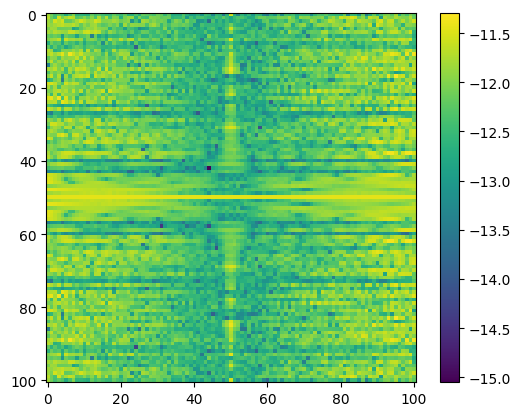

In [9]:
plt.imshow(np.log10(np.abs(hori_ppfft - true_hori_ppfft)))
plt.colorbar()

Pseudo-Polar FFT for the basically vertical lines:
$$
\forall (k, l) \in \llbracket -n//2, n//2 \rrbracket \times \llbracket -n//2, n//2 \rrbracket, \widehat{I}_v (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku - \frac{2lk}{n}v }{n+1} \right)
$$


In [10]:
def new_ppfft_vertical(a):
    return new_ppfft_horizontal(a.T)

In [11]:
vert_ppfft = new_ppfft_vertical(a)

In [12]:
true_vert_ppfft = np.empty(shape=(n + 1, n + 1), dtype=complex)

for i_l, l in enumerate(domain(n + 1)):
    for i_k, k in enumerate(domain(n + 1)):
        true_vert_ppfft[i_k, i_l] = new_slow_DTFT(a, k, -2 * l * k / n, n + 1)

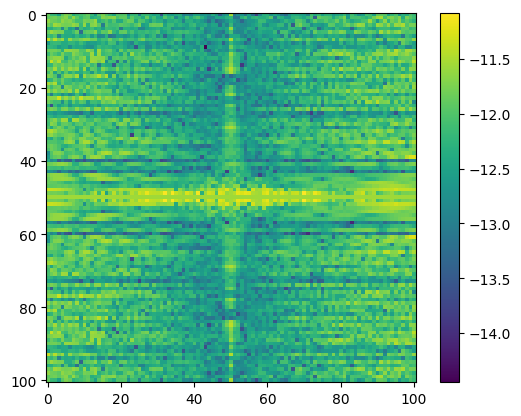

In [13]:
plt.imshow(np.log10(np.abs(vert_ppfft - true_vert_ppfft)))
plt.colorbar()

# New resampling

Convention:
$$
P_\alpha(x) = \sum_{k=0}^{n-1} \alpha(k) \exp(ikx)
$$

In [14]:
from scipy.linalg import toeplitz
from ppfft.resampling.inverse_toeplitz import InverseToeplitz
from pynufft import NUFFT

In [15]:
def trigo_poly(alpha, x):
    n = len(alpha)
    k = np.arange(n)
    kx = np.einsum("k,x->kx", k, x)
    return np.einsum("kx,k->x", np.exp(1j * kx), alpha)

In [16]:
n = 100
alpha = np.random.rand(n)
pos = np.linspace(0, -2 * np.pi, num=n, endpoint=False)
c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * pos[None, :]))
print(np.linalg.cond(toeplitz(c)))
top = InverseToeplitz(col=c)
NufftObj = NUFFT()
NufftObj.plan(om=-pos[:, None], Nd=(n,), Kd=(5 * n,), Jd=(6,))
sol = top.apply_inverse(np.fft.fftshift(NufftObj.Kd * NufftObj.adjoint(trigo_poly(alpha, pos))))

1.0000000000000413


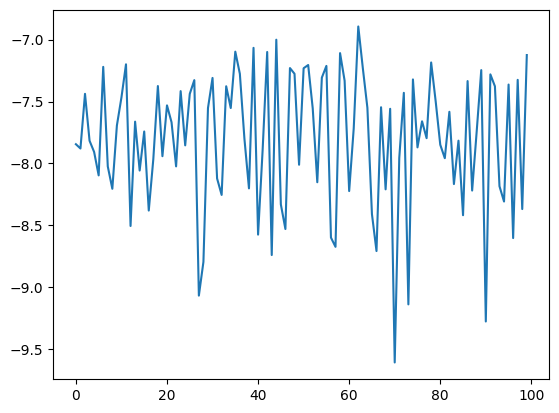

In [17]:
plt.plot(np.log10(np.abs(sol - alpha)))

In [18]:
from ppfft.inverse.fast_onion_peeling import new_find_closest

In [19]:
def trigo_poly(alpha, x):
    n = len(alpha)
    q_n, r_n = divmod(n, 2)
    k = np.arange(-q_n, q_n + r_n)
    kx = np.einsum("k,x->kx", k, x)
    return np.einsum("kx,k->x", np.exp(1j * kx), alpha)

21
16.92362264587194
2.524185299348744e-07


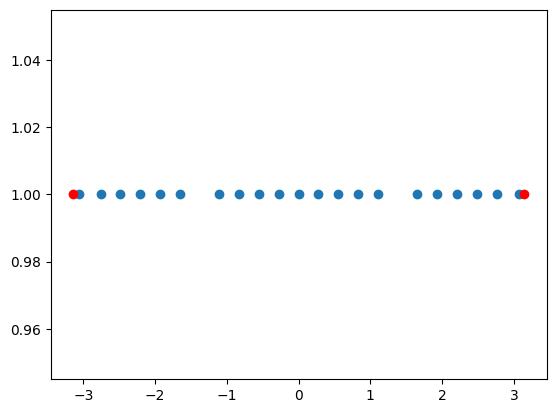

In [20]:
n = 20
m = 2 * n + 1
k = -(n//2) + 1
alpha = np.random.rand(n)
ppfft_pos = 8 * np.pi * np.arange(-(n//2), (n//2) + 1) * k / (n * m)
samples = trigo_poly(alpha, ppfft_pos)

indices = new_find_closest(k, n)
take_ppfft_pos = np.take(ppfft_pos, indices)
take_samples = np.take(samples, indices)

y_pos = -4 * np.pi * np.arange(-(n//2), k) / m
y_neg = 4 * np.pi * np.arange(-(n//2), k)[::-1] / m

y = np.concatenate((y_pos, take_ppfft_pos, y_neg)) # condition number explodes if we don not add these points
f = trigo_poly(alpha, y)

print(len(y))

plt.scatter(y, np.ones_like(y))
plt.scatter([-np.pi, np.pi], [1, 1], c='r')

c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))
print(np.linalg.cond(toeplitz(c)))
top = InverseToeplitz(col=c)
NufftObj = NUFFT()
NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(5 * n,), Jd=(6,))
sol = top.apply_inverse(NufftObj.Kd * NufftObj.adjoint(f))

print(np.max(np.abs(sol - alpha)))

In [21]:
n = 20
m = 2 * n + 1
k = -(n//2) + 1
alpha = np.random.rand(n)
ppfft_pos = 8 * np.pi * np.arange(-(n//2), (n//2) + 1) * k / (n * m)
samples = trigo_poly(alpha, ppfft_pos)

c = np.einsum("lj->l", np.exp(-1j * np.arange(0, 2 * n)[:, None] * ppfft_pos[None, :]))
print(np.linalg.cond(toeplitz(c)))
top = InverseToeplitz(col=c)
NufftObj = NUFFT()
NufftObj.plan(om=-ppfft_pos[:, None], Nd=(2 * n,), Kd=(5 * 2 * n,), Jd=(6,))
sol = top.apply_inverse(np.fft.fftshift(NufftObj.Kd * NufftObj.adjoint(samples)))

print(np.max(np.abs(sol[:n] - alpha)))

1.2197391405069389e+17
2211978300429280.5


In [22]:
def find_closest():
    l = np.arange(k, -np.sign(k) - k, step=-np.sign(k))
    return n // 2 + np.rint(-n * l / (2 * k)).astype(int)

10.351961752781431
1.5087099702304704e-07


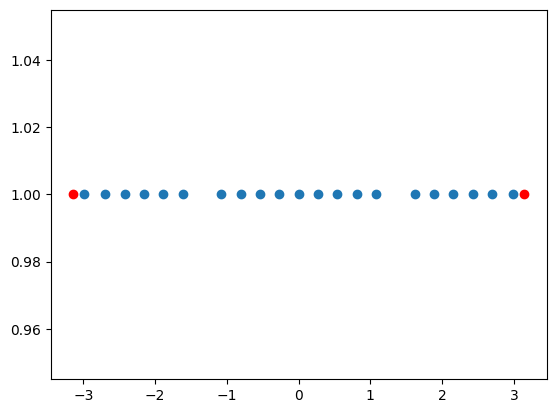

In [23]:
n = 20
alpha = np.random.rand(n)
ppfft_pos = 4 * np.pi * np.arange(-(n//2), n//2 + 1) * (-(n//2) + 1) / (n * (n + 1))
samples = trigo_poly(alpha, ppfft_pos)

indices = new_find_closest(k, n)
take_ppfft_pos = np.take(ppfft_pos, indices)
take_samples = np.take(samples, indices)

y_pos = -2 * np.pi * np.arange(-(n//2), k) / (n + 1)
y_neg = 2 * np.pi * np.arange(-(n//2), k)[::-1] / (n + 1)

y = np.concatenate((y_pos, take_ppfft_pos, y_neg)) # condition number explodes if we don not add these points
f = trigo_poly(alpha, y)

plt.scatter(y, np.ones_like(y))
plt.scatter([-np.pi, np.pi], [1, 1], c='r')

c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))
print(np.linalg.cond(toeplitz(c)))
top = InverseToeplitz(col=c)
NufftObj = NUFFT()
NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(5 * n,), Jd=(6,))
sol = top.apply_inverse(NufftObj.Kd * NufftObj.adjoint(f))

print(np.max(np.abs(sol - alpha)))

## Initialization of $\widehat{I}$

$\forall (k, l) \in \llbracket -n//2, n//2 \rrbracket \times \llbracket -n//2, n//2 \rrbracket$, we know:
$$
\widehat{I}_h (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{-\frac{2lk}{n}u + kv}{n+1} \right)
\\
\widehat{I}_v (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku -\frac{2lk}{n}v }{n+1} \right)
$$

We want:
$$
\forall (k, l) \in \llbracket -n//2, n//2 + 1 \rrbracket \times \llbracket -n//2, n//2 + 1 \rrbracket, \, 
\widehat{I}(k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku + lv}{n + 1} \right)
$$

which is the 2D FFT of $I$ (zero-padded by one).

We can see that:
$$
\widehat{I}(-n//2, l) = \widehat{I}_v(-n//2, l) \\
\widehat{I}(n//2, l) = \widehat{I}_v(n//2, -l) \\
\widehat{I}(k, -n//2) = \widehat{I}_h(-n//2, k) \\
\widehat{I}(k, n//2) = \widehat{I}_h(n//2, -k) \\
\widehat{I}(0, l) = \widehat{I}_h(l, 0) \\
\widehat{I}(k, 0) = \widehat{I}_v(k, 0) \\
\widehat{I}(k, k) = \widehat{I}_h(k, -n//2) \\
\widehat{I}(k, -k) = \widehat{I}_v(k, n//2) \\
$$

/tmp/ipykernel_568543/3164455770.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(new_fft2(pad(a, (n + 1, n + 1))) - I_hat)))


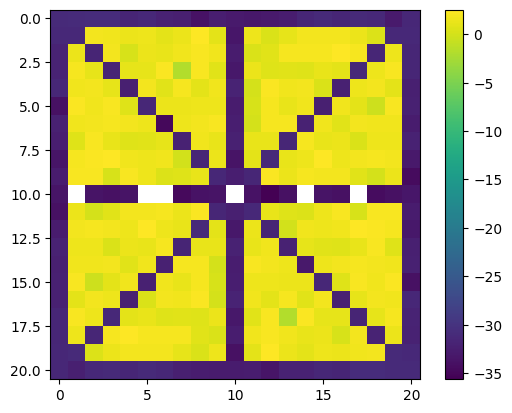

In [24]:
def initialize_I_hat(hori_ppfft, vert_ppfft):
    n = np.shape(hori_ppfft)[0] - 1
    I_hat = np.zeros_like(hori_ppfft) # shape (n + 1, n + 1)

    I_hat[0, :] = vert_ppfft[0, :]
    I_hat[-1, :] = vert_ppfft[-1, ::-1]
    I_hat[:, 0] = hori_ppfft[0, :]
    I_hat[:, -1] = hori_ppfft[-1, ::-1]
    I_hat[n//2, :] = hori_ppfft[:, n//2]
    I_hat[:, n//2] = vert_ppfft[:, n//2]
    np.fill_diagonal(I_hat, hori_ppfft[:, 0])
    np.fill_diagonal(np.fliplr(I_hat), vert_ppfft[:, -1])

    return I_hat

n = 20
a = np.random.rand(n, n)
hori_ppfft = new_ppfft_horizontal(a)
vert_ppfft = new_ppfft_vertical(a)
I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
plt.imshow(np.log(np.abs(new_fft2(pad(a, (n + 1, n + 1))) - I_hat)))
plt.colorbar()

# New onion-peeling


$$
\widehat{I}_h (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{-\frac{2lk}{n}u + kv}{n+1} \right)
\\
\widehat{I}_v (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku -\frac{2lk}{n}v }{n+1} \right)
$$

From the PPFFT samples, we would like to compute:
$$
\forall (k, l) \in \llbracket -n//2, n//2 + 1 \rrbracket^2 \, 
\widehat{I}(k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku + lv}{n + 1} \right)
$$

from $\widehat{I}_h$ and $\widehat{I}_v$. Say we want to recover row $k \in \llbracket -n//2 + 1, 0 \llbracket$ of $\widehat{I}$. The values are:
$$
\forall l \in \llbracket -n//2, n//2 + 1 \rrbracket \, 
\widehat{I}(k, l) = \sum_{v \in \mathcal{D}(n)} \left[ \sum_{u \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku}{n + 1} \right) \right]\exp\left(-2i\pi \frac{lv}{n + 1} \right)
$$

But we already know:
$$
\widehat{I}_v (k, l) = \sum_{v \in \mathcal{D}(n)} \left[ \sum_{u \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku}{n+1} \right) \right] \exp\left(-2i\pi \frac{-\frac{2lk}{n}v }{n+1} \right)
$$

which correspond to the positions $4\pi \dfrac{lk}{n (n+1)}$. We also know $\widehat{I}(k, l')$ for $l' \in \llbracket -n//2, k \rrbracket \cup \llbracket -k, n//2 \rrbracket$, which correspond to the positions $-2 \pi \dfrac{l'}{n + 1}$.


In [28]:
def precompute_onion_peeling(n: int, oversampling_factor: int = 5):
    half_n = n // 2
    toeplitz_list = []
    nufft_list = []

    for k in range(-half_n + 1, 0):
        y_ppfft = 4 * np.pi * np.arange(-(n//2), n//2 + 1) * k / (n * (n + 1))
        indices = new_find_closest(k, n)
        y_ppfft = np.take(y_ppfft, indices)

        y_pos = -2 * np.pi * np.arange(-(n//2), k) / (n + 1)
        y_neg = 2 * np.pi * np.arange(-(n//2), k)[::-1] / (n + 1)

        y = np.concatenate((y_pos, y_ppfft, y_neg))

        c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))

        toeplitz_list.append(InverseToeplitz(col=c))

        NufftObj = NUFFT()
        NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(oversampling_factor * n,), Jd=(6,))
        nufft_list.append(NufftObj)

    return toeplitz_list, nufft_list

def compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    -n//2 < k < 0
    """
    n = np.shape(I_hat)[0] - 1
    true_k = k + n//2

    I_hat_pos = I_hat[true_k, :true_k]
    I_hat_neg = I_hat[true_k, -true_k:]

    known_samples = np.concatenate((I_hat_pos, vert_ppfft_samples, I_hat_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = new_fft(pad(alpha, (n + 1,)))

    # Negative row
    I_hat[true_k, true_k + 1 : n // 2] = res[true_k + 1 : n // 2]
    I_hat[true_k, n // 2 + 1 : -true_k - 1] = res[n // 2 + 1 : -true_k - 1]
    # Positive row
    I_hat[-1 - true_k] = np.conjugate(I_hat[true_k, ::-1])

    return alpha


def compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    -(n//2) < k < 0
    """
    n = hori_ppfft.shape[0] - 1
    true_k = k + n // 2

    I_hat_pos = I_hat[:true_k, true_k]
    I_hat_neg = I_hat[-true_k:, true_k]

    known_samples = np.concatenate((I_hat_pos, hori_ppfft_samples, I_hat_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = new_fft(pad(alpha, (n + 1,)))

    # Negative column
    I_hat[true_k + 1 : n // 2, true_k] = res[true_k + 1 : n // 2]
    I_hat[n // 2 + 1 : -true_k - 1, true_k] = res[n // 2 + 1 : -true_k - 1]
    # Positive column
    I_hat[:, -1 - true_k] = np.conjugate(I_hat[::-1, true_k])

    return alpha


def onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1
    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(-(n//2) + 1, 0)):
        indices = new_find_closest(k, n)
        vert_ppfft_samples = np.take(vert_ppfft[k + n//2], indices)
        hori_ppfft_samples = np.take(hori_ppfft[k + n//2], indices)

        compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv, NufftObj)
        compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv, NufftObj)

    return I_hat

In [29]:
n = 100
toeplitz_list, nufft_list = precompute_onion_peeling(n)
a = np.random.rand(n, n)
hori_ppfft, vert_ppfft = new_ppfft_horizontal(a), new_ppfft_vertical(a)
I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
true_I_hat = new_fft2(pad(a, (n + 1, n + 1)))

In [177]:
sol = onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)

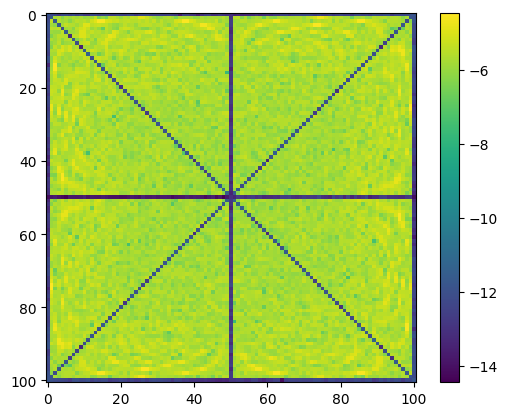

In [178]:
plt.imshow(np.log10(np.abs(true_I_hat - sol)))
plt.colorbar()

# Try reconstruction

In [337]:
def create_shepp_logan(n):
    x, y = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xx, yy = np.meshgrid(x, y)
    res = np.zeros_like(xx)

    A_list = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        rot_x = xx * np.cos(phi) + yy * np.sin(phi)
        rot_y = - np.sin(phi) * xx + yy * np.cos(phi)
        mask = (rot_x - x0)**2 / a**2 + (rot_y - y0)**2 / b**2 <= 1
        res[mask] += A

    return res[::-1]

In [309]:
n = 1000
toeplitz_list, nufft_list = precompute_onion_peeling(n)
a = create_shepp_logan(n)
hori_ppfft, vert_ppfft = new_ppfft_horizontal(a), new_ppfft_vertical(a)

In [313]:
I_hat = onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)

In [314]:
sol = new_ifft2(I_hat)[:-1, :-1].real

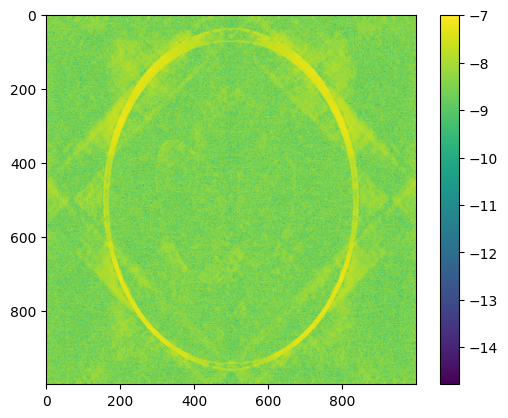

In [315]:
plt.imshow(np.log10(np.abs(sol - a)))
plt.colorbar()

# Improvement

During the onion-peeling step, we actually compute:
$$
\forall v \in \mathcal{D}(n), \, \forall k \in \rrbracket -n//2, 0 \llbracket, \, \sum_{u \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku}{n+1} \right)
$$

.

In [338]:
def onion_peeling_v2(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1

    fft_col = np.zeros(shape=(n + 1, n), dtype=complex)
    fft_col[0, :] = new_ifft(I_hat[0])[:-1]
    fft_col[-1, :] = np.conjugate(fft_col[0, :])
    fft_col[n//2, :] = new_ifft(I_hat[n//2])[:-1]

    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(-(n//2) + 1, 0)):
        indices = new_find_closest(k, n)
        vert_ppfft_samples = np.take(vert_ppfft[k + n//2], indices)
        hori_ppfft_samples = np.take(hori_ppfft[k + n//2], indices)

        fft_col[k + n//2, :] = compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv, NufftObj)
        fft_col[-(k + n//2) - 1, :] = np.conjugate(fft_col[k + n//2, :])

        compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv, NufftObj)

    return fft_col

In [339]:
def direct_inversion_v2(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    fft_col = onion_peeling_v2(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)
    return new_ifft(fft_col, axis=0)[:-1].real

In [340]:
n = 1000
toeplitz_list, nufft_list = precompute_onion_peeling(n)
a = create_shepp_logan(n)
hori_ppfft, vert_ppfft = new_ppfft_horizontal(a), new_ppfft_vertical(a)

In [317]:
fft_col = onion_peeling_v2(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)

In [319]:
sol_v2 = new_ifft(fft_col, axis=0)[:-1].real

In [321]:
%timeit new_ifft(fft_col, axis=0)[:-1].real

26.4 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


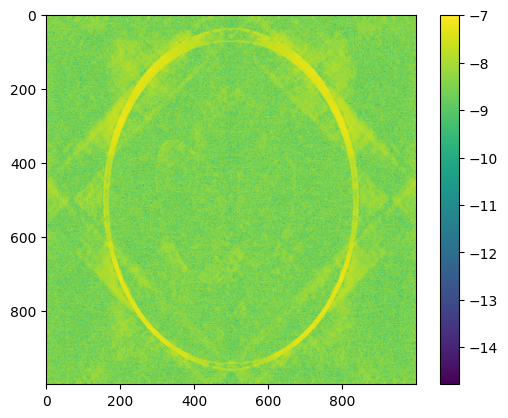

In [320]:
plt.imshow(np.log10(np.abs(sol - a)))
plt.colorbar()

In [341]:
from cProfile import run

In [342]:
run("direct_inversion_v2(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)", "../profiling/profile_direct_inversion_v2.prof")

# TO DO

- Use scipy fft instead of numpy
- try using rfft when possible